# TD Ameritrade – Python API
The TD Ameritrade API allows users to easily execute trades and pull both fundamental and technical data on all public equity and debt securities.  It also offers data on publicly traded derivatives such as stock options, index & commodity futures, and interest rate swaps.

### Set Up
1.	Go to https://developer.tdameritrade.com/
2.	Click “Register”
3.	Fill in requested fields
4.	Once Registered, click on “My Apps”
5.	Select “Add a new App”
6.	Fill out the fields as follows 
7.	Once the app is approved, click on the app name and navigate to the “KEYS” tab: 
8.	Now that your app is registered copy the “Key” from the above section, and head over to the included Jupyter notebook to test out some of the functionality of the API.

### Python Set up for the API
Now that your app is registered, you will be able to pull a wealth of info from the API.
#### Needed Packages
1.	requests
2.	pandas
3.	time
4.  matplotlib
5.  numpy
6.  seaborn
7.  statsmodels.api
8.  math
9. statistics

#### Needed Configuration Inputs
1.	Ticker file path.  This is a CSV file that you will create that has the set of tickers you wish to analyze.  Place this file in your download's folder.
2.	API Key: pulled from the developer page
3.	Define these required configurations in the Jupyter notebook:
  

### Data & Analysis

1. Downloading fundamental data
2. Downloading pricing data
3. Calculating Annualized Returns
4. Running a Regression Model 


In [39]:
######################
###Libraries & Paths##
######################

import requests
import pandas as pd
from pandas.io.json import json_normalize
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import math
import statistics

## Snagging Downloaded Files

The "get_download_path" function allows python to find your downloads folder's filepath and use it pull open your ticker list csv file.  The output of the below cell should be a list of the tickers you inputted in the ticker list csv file.


In [40]:
def get_download_path():
    """Returns the default downloads path for linux or windows"""
    if os.name == 'nt':
        import winreg
        sub_key = r'SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\Shell Folders'
        downloads_guid = '{374DE290-123F-4565-9164-39C4925E467B}'
        with winreg.OpenKey(winreg.HKEY_CURRENT_USER, sub_key) as key:
            location = winreg.QueryValueEx(key, downloads_guid)[0]
        return location
    else:
        return os.path.join(os.path.expanduser('~'), 'downloads')

ticker_path = get_download_path()+'/Ticker_List.csv'
key = 'RGOLSJPSTGVAN4NTN4DLWJE71SU7SIH0'

tickers_file = pd.read_csv(ticker_path, header=None)
tickers = []
for ticker in tickers_file.values:
    tickers.append(ticker[0])
print(tickers)

['AAPL', 'TSLA', 'MSFT']


## Manual Edits
Uncomment out the below cell and edit the list's content to replace the tickers you wish to evaluate.

In [41]:
#tickers
tickers = ['AAPL']


## Defined Functions
While this code block does not run anything on its own, it holds functions that will be used later in the program.  The TD Ameritrade API contains functions that don't always output data in the most clean (useable) format, so we have developed some functions that "scrub" the output so that it returns in a better format.  Each function will be examined more thouroughly as we go through the lecture, but they will allow us to analyze a public stock from both a quantitative and qualitative perspective.

In [42]:
def get_price_hist(ticker,period,key):
    time.sleep(1)
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/'+ticker+'/pricehistory'

    ##Define Payload
    payload = {'apikey': key,
    'periodType': 'year',
    'peirod':period,
    'frequencyType':'daily'}

    ### make request
    try:
        content = requests.get(url = endpoint, params = payload)
    except:
        print('API error, please review.')
        
    ### Convert to dictionary
    dictlist = []
    data = content.json()

    for key, value in data.items():
        temp = [key,value]
        dictlist.append(temp)
        
    try:
        hist_data = pd.DataFrame(dictlist[0][1])
        hist_data['ticker'] = ticker
        hist_data['datetime'] = pd.to_datetime(hist_data['datetime'],unit='ms')
        return hist_data
    except:
        df = pd.DataFrame()
        return df
    

def get_fundamental_from_td(ticker,key):
    time.sleep(1)
    endpoint = 'https://api.tdameritrade.com/v1/instruments'
    projection = 'fundamental'

    ##Define Payload
    payload = {'apikey': key,
               'symbol' : ticker,
                'projection': projection,
                }
    
    ### make request
    try:
        content = requests.get(url = endpoint, params = payload)
    except:
        print('API error, please review.')
        
    ### Convert to dictionary
    dictlist = []
    data = content.json()
    for key, value in data.items():
        temp = [key,value]
        dictlist.append(temp)
        
    try:
        df = pd.DataFrame(dictlist[0][1]).T.reset_index(drop=True).iloc[0]
        return df
    except:
        print(dictlist)
        df = pd.DataFrame()
        print(ticker + " not valid.")
        return df

def scrub_fundamental_data(tickers,key):
    master = pd.DataFrame()
    count = 1
    for ticker in tickers:
        temp = get_fundamental_from_td(ticker,key)
        temp = pd.DataFrame(temp).T
        hist_data = get_annual_returns([ticker],key)
        try:
            temp.columns = ['beta', 'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
           'dividendAmount', 'dividendDate', 'dividendPayAmount',
           'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
           'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
           'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
           'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
           'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
           'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
           'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
           'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
           'shortIntToFloat', 'ticker', 'totalDebtToCapital', 'totalDebtToEquity',
           'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg']
            temp = pd.merge(temp, hist_data, on='ticker')
        except:
            continue
        
        master = master.append(temp).reset_index(drop=True)
        count+= 1
    return master

def scrub_price_hist(tickers,key):
    master = pd.DataFrame()
    for ticker in tickers:
        price_data = get_price_hist(ticker,1,key)
        master = master.append(price_data, ignore_index=True)
    return master

def get_annual_returns(tickers,key):
    master = pd.DataFrame()
    for ticker in tickers:
        try:
            price_data = get_price_hist(ticker,1,key).iloc[::-1]
            return_percent = price_data['close'].iloc[0] / price_data['close'].iloc[-1] -1
            df = pd.DataFrame({"ticker":ticker,  
                               "Annual_Return_Percent":return_percent},
                               index = [0])
            master = master.append(df, ignore_index=True)
        except:

            print('error with', ticker)
    return master

## Preliminary Stock analysis
This section will show you how to calculate a stocks beta relative to a market proxy using 1 year daily data.  When
picking securities for yours or another's portolio, it is first helpful to know the risk tolerance of the investmentor
relative to the risk of investing in the broad market.  Beta will allow us to estimate this for any number of stocks, then
make relative conclusions. 


In [43]:
# This cell will get the price history for our short list.
aapl_data = scrub_price_hist(tickers,key)
aapl_data.head()

,open,high,low,close,volume,datetime,ticker
0,139.52,141.99,136.70,137.09,142621130,2021-01-28 06:00:00,AAPL
1,135.83,136.74,130.21,131.96,177523810,2021-01-29 06:00:00,AAPL
2,133.75,135.38,130.93,134.14,106239823,2021-02-01 06:00:00,AAPL
3,135.73,136.31,134.61,134.99,83305367,2021-02-02 06:00:00,AAPL
4,135.76,135.77,133.61,133.94,89880937,2021-02-03 06:00:00,AAPL


In [44]:
#To make analysis easier let's only look at the close and date and sort the date in descending order
aapl_data = aapl_data[['close','datetime','ticker']]
aapl_data = aapl_data.sort_values(by = 'datetime', ascending = False)
aapl_data.head()

,close,datetime,ticker
253,170.33,2022-01-28 06:00:00,AAPL
252,159.22,2022-01-27 06:00:00,AAPL
251,159.69,2022-01-26 06:00:00,AAPL
250,159.78,2022-01-25 06:00:00,AAPL
249,161.62,2022-01-24 06:00:00,AAPL


In [45]:
#Add a new column to show daily returns 
aapl_data['AAPL_Return_%'] = aapl_data['close'] / aapl_data['close'].shift(-1) - 1
aapl_data.rename(columns={'close': 'AAPL_Close'}, inplace=True)
aapl_data.drop(columns = ['ticker'], inplace = True)
aapl_data.head()

,AAPL_Close,datetime,AAPL_Return_%
253,170.33,2022-01-28 06:00:00,0.069778
252,159.22,2022-01-27 06:00:00,-0.002943
251,159.69,2022-01-26 06:00:00,-0.000563
250,159.78,2022-01-25 06:00:00,-0.011385
249,161.62,2022-01-24 06:00:00,-0.004864


In [46]:
# When starting an analysis of a stock, it is helpful to understand how the security performs relative to the market.
# To accomplish this, we will use the S&P 500 as a proxy for the market, and calculate the beta of the stock relative 
# to the proxy.  This cell replicates the above for ticker SPY which is one of the most liquid ETFs the tracks the S&P 500
spy_data = scrub_price_hist(['SPY'],key)
spy_data = spy_data[['close','datetime','ticker']]
spy_data = spy_data.sort_values(by = 'datetime', ascending = False)
spy_data['SPY_Return_%'] = spy_data['close'] / spy_data['close'].shift(-1) - 1
spy_data.rename(columns={'close': 'SPY_Close'}, inplace=True)
spy_data.drop(columns = ['ticker'], inplace = True)
spy_data.head()

,SPY_Close,datetime,SPY_Return_%
253,441.95,2022-01-28 06:00:00,0.024835
252,431.24,2022-01-27 06:00:00,-0.004938
251,433.38,2022-01-26 06:00:00,-0.002509
250,434.47,2022-01-25 06:00:00,-0.012209
249,439.84,2022-01-24 06:00:00,0.004247


In [59]:
#Now we'll merge the two sets
consol_data = pd.merge(aapl_data,spy_data,on=['datetime'], how = 'left').dropna() 
#note that you need to dropna because of how we calc'd returns, the last date in the set will not have a return value 

consol_data.head()


,AAPL_Close,datetime,AAPL_Return_%,SPY_Close,SPY_Return_%
0,170.33,2022-01-28 06:00:00,0.069778,441.95,0.024835
1,159.22,2022-01-27 06:00:00,-0.002943,431.24,-0.004938
2,159.69,2022-01-26 06:00:00,-0.000563,433.38,-0.002509
3,159.78,2022-01-25 06:00:00,-0.011385,434.47,-0.012209
4,161.62,2022-01-24 06:00:00,-0.004864,439.84,0.004247


In [60]:
##Now calc beta using statsmodels
x = consol_data[['SPY_Return_%']]
y = consol_data[['AAPL_Return_%']]

model = sm.OLS(y, x)
results = model.fit()
print('Beta: '+str(round(results.params[0],2)))

# How does this value compare to other sources such as Yahoo Finance (who uses a 5 year monthly model compared to 
# our 1 year daily)? Should this cause some skepticism when looking at results from models you didn't build?

Beta: 1.37


## -------------PRACTICE-------------

1. Pull the 1 year price history using the scrub_price_hist function of any stock you like.

2. Clean up the output so it mirrors our output for Apple.

3.  Think of another market proxy besides the S&P 500, pull it's data, and clean it up.

4. Merge the two data sets, so that it mirrors the 'consol_data' variable.  Then merge in the SPY data.

5. Calculate the beta of your new stock relative to both SPY and your new market proxy.  Are they different significantly?
   Consider why they may be different.

## Another common measure of risk: Volatility
Much like beta, annual standard deviation of returns (more commonly known as volatility), can be a helpful tool to guage the relative risk a particular asset poses to a portfolio.  Let's see how we might go about calculating that for Apple.

In [67]:
#Start with our Aaple data
aapl_data.head()

,AAPL_Close,datetime,AAPL_Return_%
253,170.33,2022-01-28 06:00:00,0.069778
252,159.22,2022-01-27 06:00:00,-0.002943
251,159.69,2022-01-26 06:00:00,-0.000563
250,159.78,2022-01-25 06:00:00,-0.011385
249,161.62,2022-01-24 06:00:00,-0.004864


In [87]:
# Remember that the covariance of a random variable with itself is the same as its variance.
aapl_vol = math.sqrt(pd.DataFrame([aapl_data['AAPL_Return_%'],aapl_data['AAPL_Return_%']]).T.cov().iloc[0,0])*math.sqrt(252)
print('Apple Volatility: '+str(round(aapl_vol*100,2))+'%')

Apple Volatility: 24.97%


In [88]:
# How does this compare to SPY?
spy_vol = math.sqrt(pd.DataFrame([spy_data['SPY_Return_%'],spy_data['SPY_Return_%']]).T.cov().iloc[0,0])*math.sqrt(252)
print('SPY Volatility: '+str(round(spy_vol*100,2))+'%')

SPY Volatility: 13.45%


Are these results surprising?  Think about the implications of an annual volatility of over 20%, and how such a security would
behave if it fell out of the market's favor.

## Fundamental Data
Many critics argue any form of technical analysis is a waste of time and should be avoided.  Instead, they will argue for
fundament analysis, or effectively looking at various accounting measures to understand the health of a firm, and judge it's 
performance relative to its peers.  

In [101]:
# This cell pulls the fundamental financial data from TD Ameritrade, cleans it up into a useable format and spits it out 
# in a nice table format using the Pandas package.  Note that book value per share is not
# entirely accurate, all other metrics have been vetted. 
tickers = ['AAPL','MSFT','SPY']
fundamental_data=scrub_fundamental_data(tickers,key)
fundamental_data.T

,0,1,2
beta,1.1599,0.88019,1.0064
bookValuePerShare,0,15.4153,10.9363
currentRatio,1.03781,2.2473,0
divGrowthRate3Year,0,0,0
dividendAmount,0.88,2.48,5.71821
dividendDate,2021-11-05 00:00:00.000,2022-02-16 00:00:00.000,2021-12-17 00:00:00.000
dividendPayAmount,0.22,0.62,1.63643
dividendPayDate,2021-11-11 00:00:00.000,2022-03-10 00:00:00.000,2022-01-31 00:00:00.000
dividendYield,0.52,0.8,1.29
epsChange,0,0,0


Think back to other accounting and finance courses, and assess whether you think the operating metrics of Apple seem to portray
a healthy company, or not, and if it seems overvalued based on PE or PS measures.  Remember, there really is no right or wrong answer here.  

## Get Annual Return Data
The below cell pulls the annual return data from TD Ameritrade, cleans it up into a useable format and spits it out in a nice table format using the Pandas package.

In [102]:
annual_returns_df=get_annual_returns(tickers,key)
annual_returns_df

,ticker,Annual_Return_Percent
0,AAPL,0.242468
1,MSFT,0.290169
2,SPY,0.170325


## Fundamental Data Frame Info
The next few code blocks give us information on how our data is structered, the columns it contains, the data types of the columns (string, integer, float, etc.), summary statistics, null values, etc.

In [97]:
for col in fundamental_data.columns:
    try:
        fundamental_data[col]=fundamental_data[col].astype('float')
    except:
        pass

#Data columns
fundamental_data.columns

Index(['beta', 'bookValuePerShare', 'currentRatio', 'divGrowthRate3Year',
       'dividendAmount', 'dividendDate', 'dividendPayAmount',
       'dividendPayDate', 'dividendYield', 'epsChange', 'epsChangePercentTTM',
       'epsChangeYear', 'epsTTM', 'grossMarginMRQ', 'grossMarginTTM', 'high52',
       'interestCoverage', 'low52', 'ltDebtToEquity', 'marketCap',
       'marketCapFloat', 'netProfitMarginMRQ', 'netProfitMarginTTM',
       'operatingMarginMRQ', 'operatingMarginTTM', 'pbRatio', 'pcfRatio',
       'peRatio', 'pegRatio', 'prRatio', 'quickRatio', 'returnOnAssets',
       'returnOnEquity', 'returnOnInvestment', 'revChangeIn', 'revChangeTTM',
       'revChangeYear', 'sharesOutstanding', 'shortIntDayToCover',
       'shortIntToFloat', 'ticker', 'totalDebtToCapital', 'totalDebtToEquity',
       'vol10DayAvg', 'vol1DayAvg', 'vol3MonthAvg', 'Annual_Return_Percent'],
      dtype='object')

In [98]:
#General data statistics
aapl_fundamental_data.describe()

,beta,bookValuePerShare,currentRatio,divGrowthRate3Year,dividendAmount,dividendPayAmount,dividendYield,epsChange,epsChangePercentTTM,epsChangeYear,...,revChangeYear,sharesOutstanding,shortIntDayToCover,shortIntToFloat,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg,Annual_Return_Percent
count,2.000000,2.000000,2.000000,2.0,2.000000,2.000000,2.000000,2.0,2.000000,2.000000,...,2.0,2.000000e+00,2.0,2.0,2.000000,2.000000,2.000000e+00,2.000000e+00,2.000000e+00,2.000000
mean,1.083150,5.468175,0.518905,0.0,3.299106,0.928215,0.905000,0.0,31.415075,12.382530,...,0.0,8.625237e+09,0.0,0.0,31.530325,85.357000,1.365179e+08,8.243437e+07,1.828438e+09,0.206397
std,0.108541,7.733167,0.733842,0.0,3.421132,1.001568,0.544472,0.0,44.427625,17.511542,...,0.0,1.088125e+10,0.0,0.0,44.590613,120.713027,2.769229e+07,4.812495e+07,3.018676e+08,0.051013
min,1.006400,0.000000,0.000000,0.0,0.880000,0.220000,0.520000,0.0,0.000000,0.000000,...,0.0,9.310321e+08,0.0,0.0,0.000000,0.000000,1.169365e+08,4.840489e+07,1.614986e+09,0.170325
25%,1.044775,2.734087,0.259452,0.0,2.089553,0.574108,0.712500,0.0,15.707538,6.191265,...,0.0,4.778134e+09,0.0,0.0,15.765163,42.678500,1.267272e+08,6.541963e+07,1.721712e+09,0.188361
50%,1.083150,5.468175,0.518905,0.0,3.299106,0.928215,0.905000,0.0,31.415075,12.382530,...,0.0,8.625237e+09,0.0,0.0,31.530325,85.357000,1.365179e+08,8.243437e+07,1.828438e+09,0.206397
75%,1.121525,8.202262,0.778357,0.0,4.508658,1.282323,1.097500,0.0,47.122613,18.573795,...,0.0,1.247234e+10,0.0,0.0,47.295488,128.035500,1.463086e+08,9.944911e+07,1.935164e+09,0.224433
max,1.159900,10.936350,1.037810,0.0,5.718211,1.636431,1.290000,0.0,62.830150,24.765060,...,0.0,1.631944e+10,0.0,0.0,63.060650,170.714000,1.560993e+08,1.164638e+08,2.041891e+09,0.242468


In [99]:
# Data Frame information (null, data type etc)
aapl_fundamental_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   beta                   2 non-null      float64
 1   bookValuePerShare      2 non-null      float64
 2   currentRatio           2 non-null      float64
 3   divGrowthRate3Year     2 non-null      float64
 4   dividendAmount         2 non-null      float64
 5   dividendDate           2 non-null      object 
 6   dividendPayAmount      2 non-null      float64
 7   dividendPayDate        2 non-null      object 
 8   dividendYield          2 non-null      float64
 9   epsChange              2 non-null      float64
 10  epsChangePercentTTM    2 non-null      float64
 11  epsChangeYear          2 non-null      float64
 12  epsTTM                 2 non-null      float64
 13  grossMarginMRQ         2 non-null      float64
 14  grossMarginTTM         2 non-null      float64
 15  high52    

## Correlation Map
Let's combine some quantitative analysis with our qualitiative data, and see which fundamental indicators are potentially meaningful performance indicators.

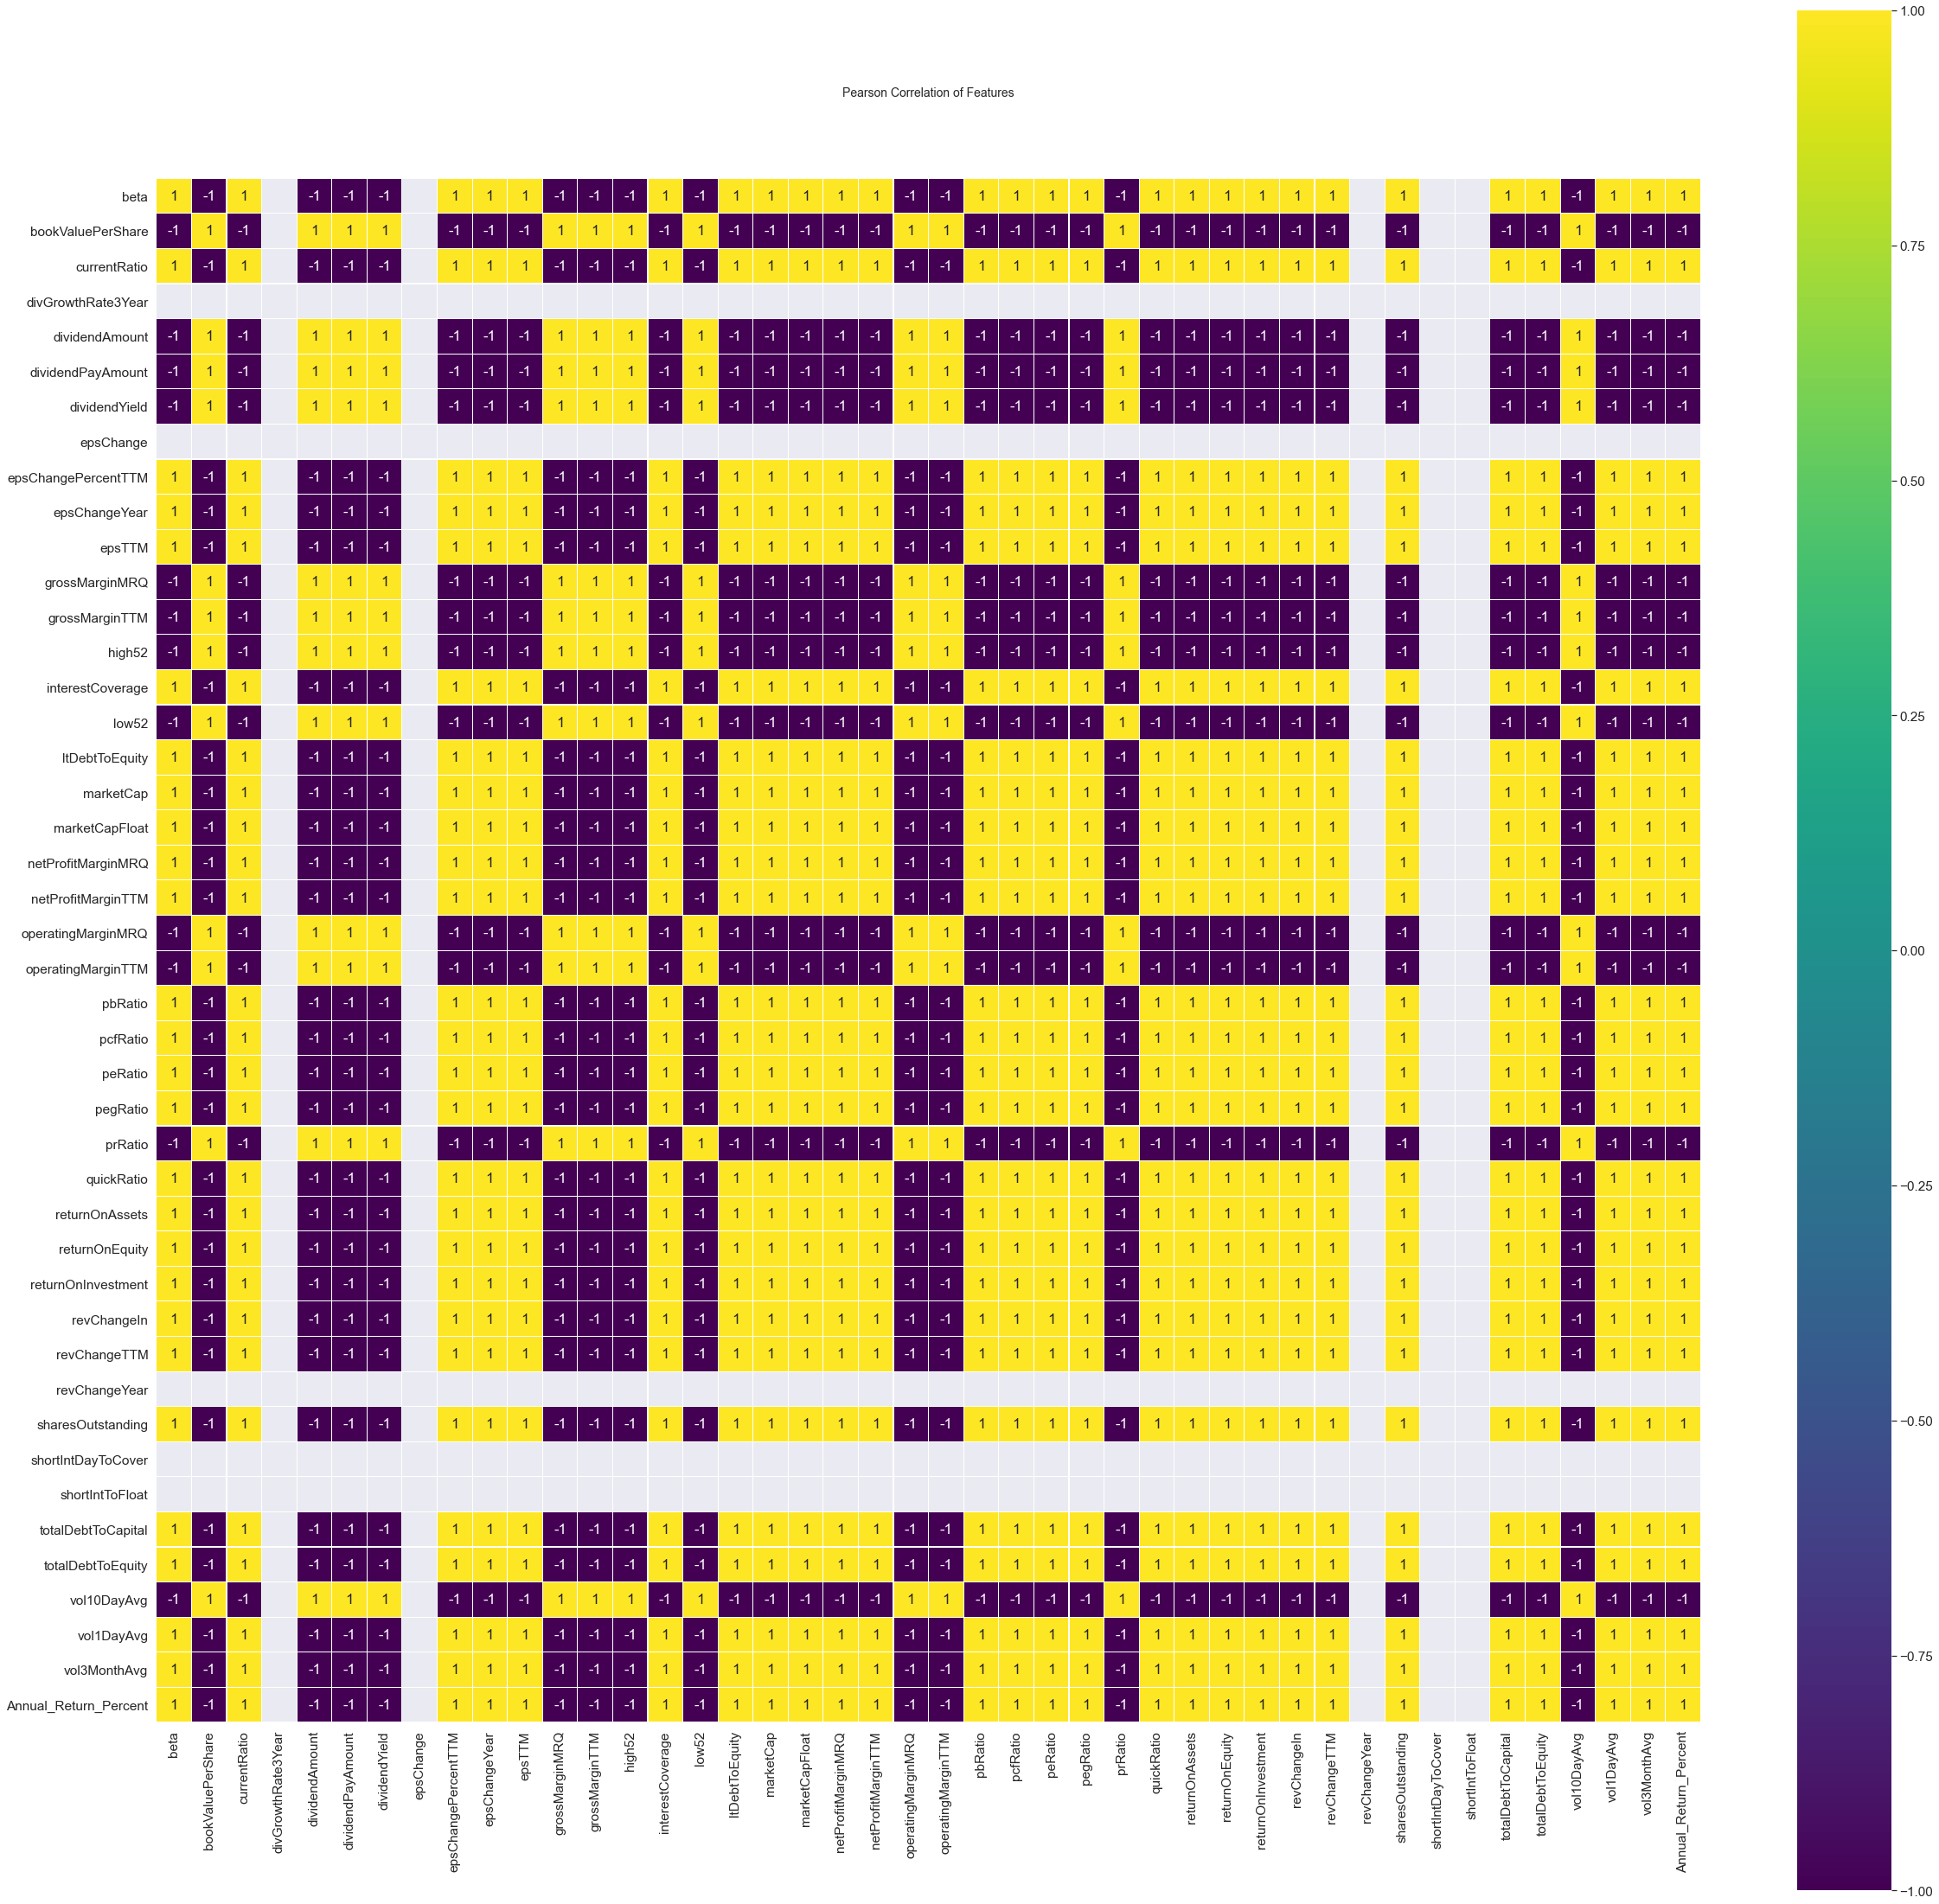

In [100]:
# Uncorrelated features are generally more powerful predictors
colormap = plt.cm.viridis
plt.figure(figsize=(40, 40))
plt.title('Pearson Correlation of Features', y=1.05, size=14)
sns.set(font_scale=1.4)
sns.heatmap(aapl_fundamental_data.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

## Linear Regression

In [ ]:
x = scrubbed_fundamental_data[['beta', 'pcfRatio', 'returnOnAssets','quickRatio','dividendYield']] # Independent variables
y = scrubbed_fundamental_data["Annual_Return_Percent"] # Response / Target Variable

print(x.shape, y.shape)
x=sm.add_constant(x)
result=sm.OLS(y,x).fit()
print(result.summary())

## Regression Results
The above regression results show us that by only looking five fundamental metrics, we are able to explain nearly 50% of the movement in the stocks analyzed (per R-squared).  Additionally, it is usefuly to look at the Prob (F-statistic) and Prob(Jarque-Bera) as these two statistical tests are crucial gauges of model efficacy.  Specifically, if both values are under .05, we can reasonable assume the variables used in the model are meaningful indicators.  

# TD API: A Risk Management Study
Understanding the risk of a portfolio of stocks is often times just as crucial, if not more so, than understanding its growth opportunities.  In this exercise we will examine a portfolio that has equal weights in APPL and TSLA, and attempt to gauge how much capital we are putting at risk by holding this portfolio.  To keep math simple, we will assume that the portfolio is valued at $50,000.  

## Value at Risk
Value at Risk, or simply VaR, has been around for decades, and is considered the gold standard for the benchmark of porfolio risk.  Barring any significant shifts in company health or direction, VaR can be thought of as largest paper loss an investor will see over a predefined time horizon by holding a security(s).  We will look at one month VaR, and choose a confidence level of 95% in order to have a high degree of confidence that we are in fact looking at a reasonable worst case.  While it can be beneficial to look at the 99% case, 95% will be a good start.  With our parameters defined, VaR can be calculated as follows:

VaR = Portfolio Volatility * Portfolio Value * 1.65

In [ ]:
###Define Portfolio Inputs
aapl_weight = .5
tsla_weight = .5
portfolio_value = 50000
days_into_future = 30
tickers = ['TSLA','AAPL']

In [ ]:
###Grab Price History
price_hist = scrub_price_hist(tickers,key)
price_hist = price_hist[['close','ticker','datetime']]


###Calculate Portfolio Volatility
count = 0
for ticker in tickers:
    if count == 0:
        temp = price_hist[price_hist['ticker'] == ticker]
        temp[ticker +'_Return_%'] = temp['close'] / temp['close'].shift(1) - 1
        temp = temp.dropna()
        temp = temp.drop(['close','ticker'], axis = 1)
        master = temp
        count = 1
    else:
        temp = price_hist[price_hist['ticker'] == ticker]
        temp[ticker +'_Return_%'] = temp['close'] / temp['close'].shift(1) - 1
        temp = temp.dropna()
        temp = temp.drop(['close','ticker'], axis = 1)
        master = pd.merge(master,temp,how = 'left',on = ['datetime'])


consol_returns = pd.DataFrame([master[tickers[0] + '_Return_%']*tsla_weight,master[tickers[1] + '_Return_%']*aapl_weight]).T
port_volatility = math.sqrt(consol_returns.cov().to_numpy().sum())*math.sqrt(days_into_future)

###Calculate Individual Security Volatilities
sec_vols = []        
for ticker in tickers:
    temp = [ticker,(math.sqrt(days_into_future)*math.sqrt(statistics.variance(master[ticker + '_Return_%'])))]
    sec_vols.append(temp)



###Compare individual security volatility to Portfolio Volatility
for i in range (0,len(tickers)):
    print(tickers[i] + ' Volatility: ',round(sec_vols[i][1]*100,2),'%')
print('Portfolio Volatility: ',round(port_volatility*100,2),'%')


In [ ]:
###Calculate VaR
VaR = portfolio_value * 1.65 * port_volatility
print('$',round(VaR,2))


## Conclusions

By holding a \\$50,000 portfolio that is equally weighted in AAPL and TSLA stock, an investor should be comfortable with a significant likelihood of losing \\$16,000+ over the course of one month.  